In [1]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import os

## Prototyping an augmentation pipeline segmentation

### Step 1: Basic utils

* `draw_circle()` draws a circle on an image on a given center with a radius. In our case, we've set `thickness = -1`, this means that the circle would be completely filled. 
* `read_and_shrink_image()` reads an image in grayscale and shrinks an image by a factor of `shrink_factor**2`

In [2]:
def draw_circle(image, vertex, radius, thickness = 5):

    ## vertex = (x, y)
    with_circle = cv2.circle(
                            image,                
                            vertex, 
                            radius = radius, 
                            color = (255, 255, 255),  ## (B, G, R) 
                            thickness = thickness)
    return with_circle

def read_and_shrink_image(image_path, shrink_factor = 2):
    raw_img = cv2.imread(image_path, 0) ## 0 means grayscale = 1 color channel 
    raw_img_small = cv2.resize(raw_img, (int(raw_img.shape[1]/shrink_factor), int(raw_img.shape[0]/shrink_factor)))
    return raw_img_small

### Viewing the original image

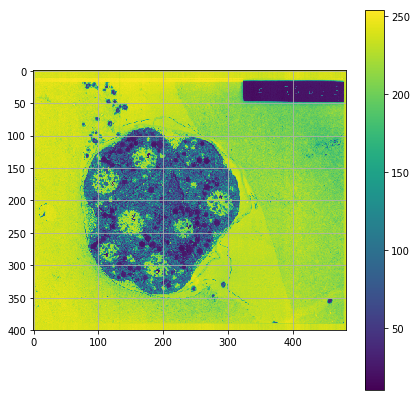

In [8]:
plt.rcParams['figure.figsize'] = 7, 7

im_real = read_and_shrink_image("data/original_images/sample.jpg", shrink_factor = 5)

plt.imshow(im_real)
plt.colorbar()
plt.grid()
plt.show()

### Step 2: Manually drawing circles over the nuclei

In [9]:
im = read_and_shrink_image("data/original_images/sample.jpg", shrink_factor = 5)

t = -1

circled = draw_circle(im, (172,132), radius = 17, thickness = t)
circled = draw_circle(circled, (112,170), radius = 19, thickness = t)
circled = draw_circle(circled, (150,233), radius = 18, thickness = t)
circled = draw_circle(circled, (115,280), radius = 16, thickness = t)
circled = draw_circle(circled, (190,300), radius = 16, thickness = t)
circled = draw_circle(circled, (231,243), radius = 14, thickness = t)
circled = draw_circle(circled, (287,203), radius = 18, thickness = t)

overlay = circled 

In [10]:
annotation = np.zeros(im.shape)

circled = draw_circle(annotation, (172,132), radius = 17, thickness = t)
circled = draw_circle(circled, (112,170), radius = 19, thickness = t)
circled = draw_circle(circled, (150,233), radius = 18, thickness = t)
circled = draw_circle(circled, (115,280), radius = 16, thickness = t)
circled = draw_circle(circled, (190,300), radius = 16, thickness = t)
circled = draw_circle(circled, (231,243), radius = 14, thickness = t)
circled = draw_circle(circled, (287,203), radius = 18, thickness = t)

annotation = circled 

## Viewing the overlays 

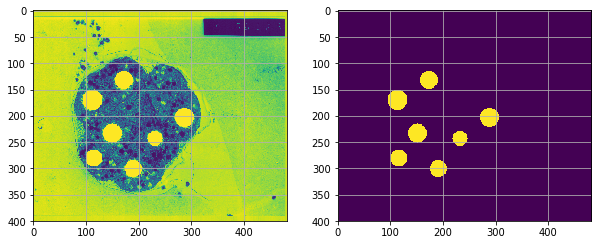

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,10))

ax.flat[0].imshow(overlay)
ax.flat[0].grid()
ax.flat[1].imshow(annotation)
ax.flat[1].grid()

## Building the augmentation pipeline
* We have to make sure that the image and the mask goes through the "exact" set of transforms to maintain integrity.
* For our case, we use [albumentations](https://github.com/albumentations-team/albumentations) library for augmentation.

In [0]:
!pip install albumentations

In [12]:
cv2.imwrite("data/masks/mask.png", annotation)
cv2.imwrite("data/images/image.png", im_real)

True

In [13]:
from albumentations import (
                            PadIfNeeded,
                            HorizontalFlip,
                            VerticalFlip,    
                            CenterCrop,    
                            Crop,
                            Compose,
                            RandomRotate90,
                            RandomBrightnessContrast,
                            ElasticTransform,
                            GridDistortion, 
                            OpticalDistortion,
                            RandomSizedCrop,
                        )

In [14]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [15]:
image = cv2.imread("data/images/image.png",0)
mask = cv2.imread("data/masks/mask.png",0)
original_height, original_width = image.shape[:2]

## Trying out a few augmentation techniques on the sample
* `p` is a common argument among all the transforms, it specifies the probability of execution of the given transform. `p = 1` means it'll occur on every image that passes through it. 

Given below are a few augmented samples that would be used in the pipeline:

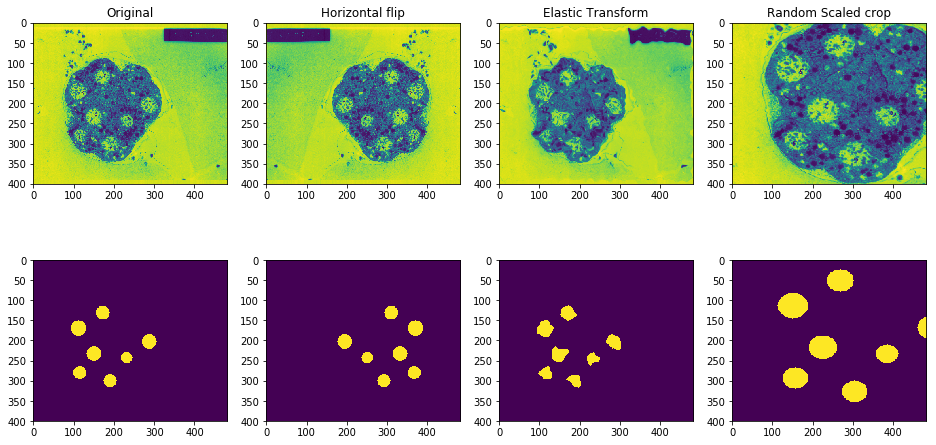

In [42]:
aug = HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

aug = ElasticTransform(p=1, alpha=90, sigma=110 * 0.05, alpha_affine=120 * 0.03)

augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

aug = RandomSizedCrop(p=1, min_max_height=(220, 400), height=original_height, width=original_width)

augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']



f, ax = plt.subplots(2, 4, figsize=(16, 8))

ax[0][0].imshow(image)
ax[1][0].imshow(mask)
ax[0][0].title.set_text('Original')


ax[0][1].imshow(image_h_flipped)
ax[1][1].imshow(mask_h_flipped)
ax[0][1].title.set_text('Horizontal flip')



ax[0][2].imshow(image_elastic)
ax[1][2].imshow(mask_elastic)
ax[0][2].title.set_text('Elastic Transform')



ax[0][3].imshow(image_scaled)
ax[1][3].imshow(mask_scaled)
ax[0][3].title.set_text('Random Scaled crop')


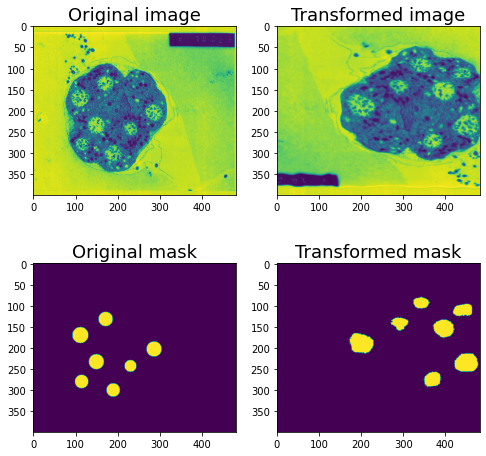

In [182]:
aug = Compose([
               ElasticTransform(p=1, alpha=50, sigma=120 * 0.05, alpha_affine=120 * 0.03),
               VerticalFlip(p=0.5),
               HorizontalFlip(p=0.5),
               RandomRotate90(p=0.5),
               GridDistortion(p=1),
               RandomSizedCrop(min_max_height=(250, 400), height=original_height, width=original_width, p=1),
               RandomBrightnessContrast( p=0.5)           
            ])

augmented = aug(image=image, mask=mask)

image_medium = augmented['image']
mask_medium = augmented['mask']

visualize(image_medium, mask_medium, original_image=image, original_mask=mask)